## Analysing, preprocessing, and transforming image datasets

### Introduction

We’ll explore how to load, inspect, and prepare an image dataset for use in machine learning and deep learning tasks. Working with image data involves a few extra steps compared to text or tabular data, but the principles are similar: understand what you have, clean and prepare it, and then structure it for modelling.

We’ll use the popular *Cats and Dogs* dataset as an example—a classic binary classification task where the goal is to teach a model to tell the difference between images of cats and dogs.

This walkthrough will cover five key areas:

- *Loading the Image Dataset* – How to read images from folders, organise them with labels, and view a few examples to check that everything looks correct.

- *Exploratory Data Analysis (EDA)* – Analysing basic properties of the dataset, such as how many images are in each class, and image size and number of channels.

When you understand how to handle image data effectively, you can create more robust models and avoid common pitfalls like overfitting, poor generalisation, or input mismatches. This foundation is essential whether you're building a simple classifier or a more complex computer vision system.

### Installing required libraries

In [1]:
%pip install numpy pandas matplotlib seaborn opencv-python tensorflow keras -q

Note: you may need to restart the kernel to use updated packages.


### Downloading the dataset

We will use the *Cats and Dogs dataset*, a well-known benchmark for image classification tasks. The dataset consists of images of two categories stored in a directory `./cats_dogs/train/`:

```
./cats_dogs/train/
    cats/
      cat_1.jpg
      cat_2.jpg
      ...
    dogs/
      dog_1.jpg
      dog_2.jpg
      ...
```
Once downloaded, we unpack the dataset and find that each image is stored in the relevant folder, which represents our target label, `cats/` or `dogs/`:

In [2]:
import os
import urllib.request
import zipfile

# Define URL and target filenames
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = "cats_and_dogs_filtered.zip"
extract_dir = "cats_dogs"

# Download the zip file
print("Downloading dataset...")
urllib.request.urlretrieve(url, zip_path)
print("Download complete.")

# Extract the zip file
print("Extracting files...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Extraction complete.")

# Delete the zip file
print("Cleaning up...")
os.remove(zip_path)
print("Cleanup complete.")


Download complete.
Extracting files...
Extraction complete.
Cleaning up...
Cleanup complete.


### Loading the image data

To load the image data, we walk through each directory and collate the filenames. We first define the root directory for our data `dataset_path`, then the two classes in `category_path`:

In [3]:
import os                    # For file and directory operations
import cv2                   # OpenCV for image loading and processing
import numpy as np           # For numerical operations (not used yet, but useful later)
import matplotlib.pyplot as plt  # For plotting and visualization

# Define the root path to the training dataset
dataset_path = "cats_dogs/cats_and_dogs_filtered/train/"  # Adjust this to your dataset location

# Define class labels - these should correspond to subfolders inside the dataset path
category_path = ["cats", "dogs"]

# Prepare lists to store image paths and their corresponding labels
image_files = []
labels = []

limit = 500  # Maximum number of images to load per category (to reduce load for initial EDA)

# Load up to `limit` images PER CATEGORY (cats and dogs)
for category in category_path:
    full_category_path = os.path.join(dataset_path, category)  # Full path to category folder
    count = 0  # Counter for how many images we've added from this category

    for file in os.listdir(full_category_path):
        if file.endswith(('png', 'jpg', 'jpeg')):
            image_files.append(os.path.join(full_category_path, file))
            labels.append(category)
            count += 1

            if count >= limit:
                break  # Stop after `limit` images from this category


# Raise an error if no images were found (to catch path issues early)
if not image_files:
    raise ValueError("No images found! Check the dataset path and file extensions.")

# Output the number of images loaded
print(f"Total images loaded: {len(image_files)}")


Total images loaded: 1000


### Visualising the dataset
To get a quick visual overview of our image dataset, we randomly select a few pictures of cats and dogs and display them side by side. To achieve this, the code below performs the following:

1. It picks 5 random cat images and 5 random dog images from the dataset.  
2. It loads these images and converts them into a format suitable for displaying in colour.  
3. It arranges the selected images in a tidy grid: one row for cats and another for dogs, each labelled with a simple title.

This is a straightforward and helpful way to visually explore the data before training a machine learning model. It helps confirm that the images are loading correctly and gives us a sense of the kind of pictures the model will be learning from:

[('cats_dogs/cats_and_dogs_filtered/train/cats/cat.952.jpg', 'cats'),
 ('cats_dogs/cats_and_dogs_filtered/train/cats/cat.946.jpg', 'cats'),
 ('cats_dogs/cats_and_dogs_filtered/train/cats/cat.6.jpg', 'cats'),
 ('cats_dogs/cats_and_dogs_filtered/train/cats/cat.749.jpg', 'cats'),
 ('cats_dogs/cats_and_dogs_filtered/train/cats/cat.991.jpg', 'cats')]

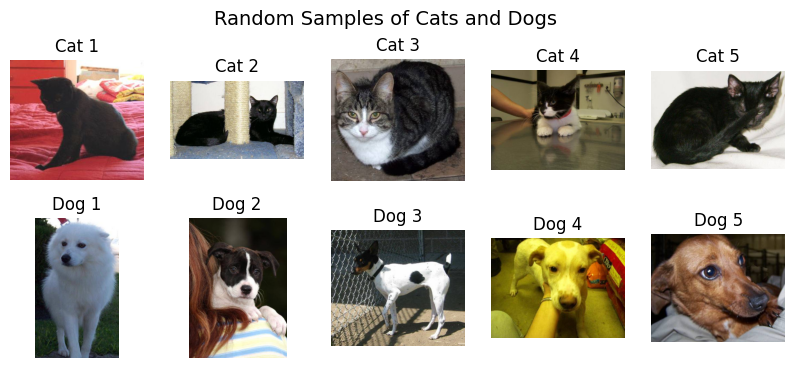

In [10]:
import random  # For selecting random samples

# Select 5 random image paths for each category (cats and dogs)
cat_images = random.sample([img for img, label in zip(image_files, labels) if label == 'cats'], 5)
dog_images = random.sample([img for img, label in zip(image_files, labels) if label == 'dogs'], 5)

# Load each selected image and convert it from BGR (OpenCV default) to RGB (for accurate colour display)
cat_imgs = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in cat_images]
dog_imgs = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in dog_images]

# Create a 2-row grid of subplots: one row for cats, one for dogs, 5 images in each
fig, ax = plt.subplots(2, 5, figsize=(10, 4))  # 2 rows × 5 columns of image slots

# Loop to display the cat and dog images in the grid
for i in range(5):
    # Display each cat image in the top row
    ax[0, i].imshow(cat_imgs[i])      # Show image
    ax[0, i].axis('off')              # Hide axes for a cleaner look
    ax[0, i].set_title(f'Cat {i+1}')  # Add title

    # Display each dog image in the bottom row
    ax[1, i].imshow(dog_imgs[i])
    ax[1, i].axis('off')
    ax[1, i].set_title(f'Dog {i+1}')

# Add an overall title to the figure
plt.suptitle("Random Samples of Cats and Dogs", fontsize=14)

# Show the figure
plt.show()

### Descriptive statistics for images
Exploratory Data Analysis (EDA) is a crucial step in machine learning and deep learning projects involving images. It helps us understand the dataset, detect potential imbalances, inconsistencies, or anomalies, and make informed preprocessing decisions before training models.

For image datasets, EDA typically involves:

- Checking dataset distribution (number of images per class).
- Examining image sizes, resolutions, and color channels to standardise input data.
- Visualising sample images to understand quality and variability.

Before we train a machine learning model with our cat and dog images, it's important to understand what those images actually look like behind the scenes. We will check some basic properties of the images—specifically their *size* and *colour format*. 

Why does this matter?

- *Image size matters*: If your images are all different sizes, they usually need to be resized to a consistent shape before training a model.
- *Checking colour format*: Most models expect colour images with 3 channels (red, green, blue). If some images are black and white (1 channel), this could cause problems.
- *Quality control*: Helps identify if any images are broken, too small, or in the wrong format before we go further.

In short, this is a quick “health check” of the dataset to make sure the images are ready for machine learning.

In this next step, we check the dimensions of each image: how tall and wide they are, and whether they're in colour. This gives us a quick overview of the dataset and helps us spot any problems—like images that are too small or in the wrong format:


In [11]:
# Define quality control thresholds
min_height = 100  # Minimum acceptable image height in pixels
min_width = 100   # Minimum acceptable image width in pixels
expected_channels = 3  # Expecting RGB images (3 colour channels)

# Lists to collect any problematic images for review
broken_images = []         # Images that couldn't be read (possibly corrupted)
small_images = []          # Images that are smaller than the minimum size
wrong_format_images = []   # Images with the wrong number of colour channels

# Go through each image in the dataset
for img_path in image_files:
    img = cv2.imread(img_path)  # Attempt to read the image using OpenCV

    if img is None:
        # If image loading fails, mark it as broken
        broken_images.append(img_path)
        continue  # Skip to the next image

    height, width, channels = img.shape  # Get image dimensions and number of channels

    # Check if image is too small
    if height < min_height or width < min_width:
        small_images.append((img_path, (width, height)))  # Save path and actual size

    # Check if image does not have the expected number of colour channels (RGB = 3)
    if channels != expected_channels:
        wrong_format_images.append((img_path, channels))  # Save path and number of channels

# Print summary of quality check results
print(f"Broken images (unreadable): {len(broken_images)}")
print(f"Images too small (< {min_width}x{min_height}): {len(small_images)}")
print(f"Images with unexpected number of channels: {len(wrong_format_images)}")


Broken images (unreadable): 0
Images too small (< 100x100): 9
Images with unexpected number of channels: 0


In [12]:
# Optionally print examples from each issue category (up to 5)
if broken_images:
    print("\nExample broken images:")
    print("\n".join(broken_images[:5]))

if small_images:
    print("\nExample small images:")
    for path, size in small_images[:5]:
        print(f"{path} - {size}")

if wrong_format_images:
    print("\nExample wrong format images:")
    for path, ch in wrong_format_images[:5]:
        print(f"{path} - {ch} channels")


Example small images:
cats_dogs/cats_and_dogs_filtered/train/cats/cat.575.jpg - (99, 149)
cats_dogs/cats_and_dogs_filtered/train/cats/cat.664.jpg - (75, 199)
cats_dogs/cats_and_dogs_filtered/train/dogs/dog.990.jpg - (100, 74)
cats_dogs/cats_and_dogs_filtered/train/dogs/dog.943.jpg - (90, 99)
cats_dogs/cats_and_dogs_filtered/train/dogs/dog.69.jpg - (128, 95)


Next, calculating the average image size and checking how many colour channels are used, ensures the images are consistent and ready to be processed. It’s a simple but crucial step to avoid issues later on:

In [13]:
# Check image shapes
image_shapes = [cv2.imread(img).shape for img in image_files]
# Let's break down what this line does step by step:

# 1. First, let's see what image_shapes looks like:
# image_shapes = [(height1, width1, channels1), (height2, width2, channels2), ...]

# 2. The * operator unpacks the list of tuples, so it's equivalent to:
# zip((height1, width1, channels1), (height2, width2, channels2), ...)

# 3. zip() then groups corresponding elements together:
# - First group: (height1, height2, ...) -> becomes heights
# - Second group: (width1, width2, ...) -> becomes widths
# - Third group: (channels1, channels2, ...) -> becomes channels

# 4. Finally, these three groups are assigned to the variables:
heights, widths, channels = zip(*image_shapes)

print(f'Number of images: {len(image_files)}')
print(f'Average Image Height: {np.mean(heights):.2f}')
print(f'Average Image Width: {np.mean(widths):.2f}')
print(f'Number of Channels: {set(channels)}')

Number of images: 1000
Average Image Height: 358.07
Average Image Width: 402.99
Number of Channels: {3}


One important aspect of data analysis is checking whether our dataset is balanced. Below, we generate a *bar chart* to visualise how many images are present per class. This helps us understand whether we need to apply techniques such as *data augmentation* to expand one or more of the classes, to improve model training:

In [14]:
import os              # For working with file and folder paths
import numpy as np     # For handling image data as arrays
from PIL import Image  # Pillow library for opening and processing images

# Define the two classes in the dataset, stored in separate folders
classes = ['dogs', 'cats']

# Lists to store the image data (X) and the corresponding labels (y)
X = []  # Will contain image arrays
Y = []  # Will contain class labels (0 for dogs, 1 for cats)

# Create a dictionary to count how many images are loaded from each class
class_counts = {class_name: 0 for class_name in classes}

# Loop through each class folder and process the images
for label_index, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)  # Full path to the class folder

    # Loop through all files in the folder
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):  # Only process .jpg image files
            img_path = os.path.join(class_path, filename)  # Full path to the image

            # Open the image and ensure it's in RGB format (3 colour channels)
            img = Image.open(img_path).convert('RGB')

            # Resize the image to 64x64 pixels for consistency and lower computation
            img = img.resize((64, 64))

            # Convert the image to a NumPy array so it can be used in machine learning
            img_array = np.array(img)  # Shape will be (64, 64, 3)
            X.append(img_array)        # Add image data to the list
            Y.append(label_index)      # Add numeric label (0 or 1)

            # Update the count for this class
            class_counts[class_name] += 1

# Print how many images were loaded from each class
print(class_counts)


{'dogs': 1000, 'cats': 1000}


Text(0.5, 1.0, 'Dataset Distribution')

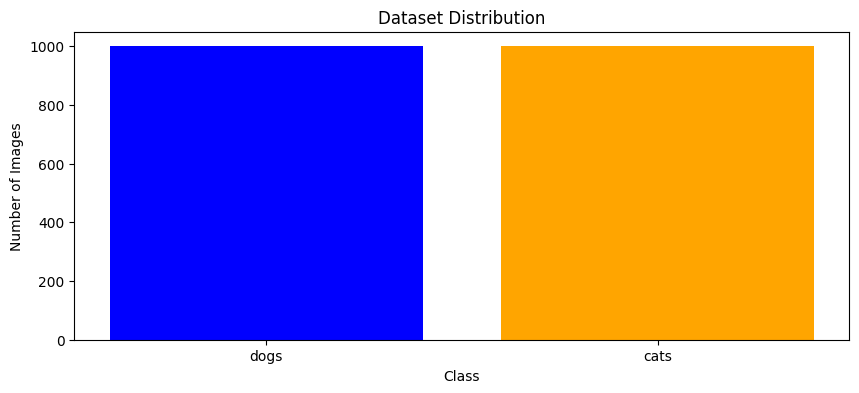

In [15]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(10, 4))

plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])

plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.title('Dataset Distribution')

In our example, we've taken a sample of the data with an equal number of images from each class. However, in real-world scenarios, datasets are often *not* perfectly balanced—unless they've been deliberately curated that way. That's why checking the class distribution is an important first step, as it helps you anticipate any issues you might need to address depending on the type of model you're planning to use.

### Visualising the impact of preprocessing

Preprocessing is a crucial step in preparing image data for machine learning and deep learning models. It ensures consistency across the dataset, improves computational efficiency, and enhances model performance. The three key preprocessing techniques covered here are:

- Resizing – Ensures all images have the same dimensions, as deep learning models require uniform input sizes.
- Normalisation – Scales pixel values to a standard range (e.g., 0 to 1) to stabilise training and improve convergence.
- Greyscale Conversion – Converts RGB images to a single channel to reduce complexity, especially when colour is not a significant feature.

### Resizing Images
Images in real-world datasets come in different sizes, as we have seen above. To ensure consistency, we resize them to a fixed shape before feeding them into a model.

### Normalising images
Normalisation scales pixel values to a range (e.g., 0 to 1) instead of 0 to 255. This helps to improve model convergence during training, prevent numerical instability, and standardise input for neural networks. In short, it prevents large pixel values from dominating in deep learning models, and ensures consistency across different images.

Below we write a function `preprocess_image`, to perform resizing, and normalisation in one go before visualising the results:

In [16]:
import numpy as np
import cv2

# Define a function to resize and normalise an image
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)  # Resize image
    image = image / 255.0  # Normalise pixel values
    return image

# Ensure image_files is defined
if 'image_files' not in locals():
    raise ValueError("Error: image_files is not defined. Load the dataset first.")

# Apply preprocessing to all images
processed_images = np.array([preprocess_image(img) for img in image_files])

print(f'Processed Image Dataset Shape: {processed_images.shape}')


Processed Image Dataset Shape: (1000, 128, 128, 3)


The values returned as the image dataset shape `(1000, 128, 128, 3)`, describe the structure of our processed image data in numerical terms. Here’s what each number means:

- 1000 – The total number of images in the dataset

- 128 – The height of each image in pixels (after resizing)

- 128 – The width of each image in pixels

- 3 – The number of colour channels (Red, Green, Blue)

So this tells us that we have 1,000 colour images, each resized to 128×128 pixels, ready for model training or further analysis. To visualise the effects of preprocessing, we will select a random image to ensure everything appears as expected:

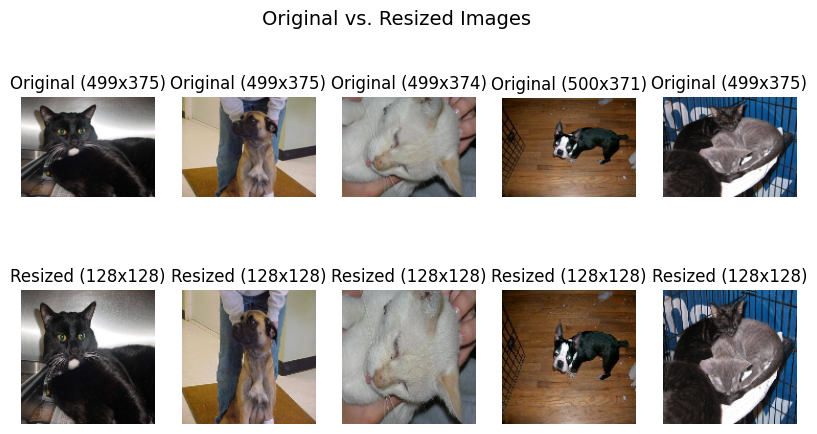

In [17]:
import random

# Select a random sample image
sample_image_path = random.choice(image_files)

# Select 5 random images for visualisation
sample_indices = random.sample(range(len(image_files)), 5)

# Plot original and resized images side by side
fig, ax = plt.subplots(2, 5, figsize=(10, 5))

for i, idx in enumerate(sample_indices):
    # Load original image
    original = cv2.cvtColor(cv2.imread(image_files[idx]), cv2.COLOR_BGR2RGB)

    # Get resized version
    resized = processed_images[idx]  # normalised and resized

    # Show original
    ax[0, i].imshow(original)
    ax[0, i].axis('off')
    ax[0, i].set_title(f"Original ({original.shape[1]}x{original.shape[0]})")

    # Show resized
    ax[1, i].imshow(resized)
    ax[1, i].axis('off')
    ax[1, i].set_title("Resized (128x128)")

plt.suptitle("Original vs. Resized Images", fontsize=14)
plt.show()


### Converting images to Greyscale
If colour is not an important feature, greyscale images reduce the number of channels from 3 (RGB) to 1, decreasing model complexity. Plotting the results, enables us to check how successful this step was:

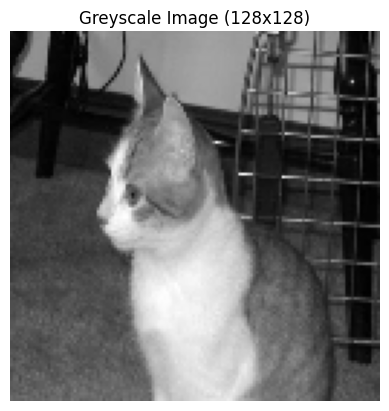

In [18]:
# Define a function to convert an image to greyscale
def convert_to_greyscale(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # We read image in greyscale mode
    image = cv2.resize(image, target_size)  # Resize image
    image = image / 255.0  # Normalise pixel values
    return image

# Apply greyscale conversion to all images
greyscale_images = np.array([convert_to_greyscale(img) for img in image_files])

# Display a sample greyscale image
plt.imshow(greyscale_images[0], cmap='gray')
plt.axis('off')
plt.title("Greyscale Image (128x128)")
plt.show()


This reduces computational complexity (fewer channels = fewer computations). So, this is useful for tasks like digit recognition (MNIST) where colour is irrelevant.

### Showing a comparison: original vs. preprocessed
Lets now visualise and compare the outputs of all preprocessing steps including the original, resized, normalised, and greyscale image variants across our sample of images:

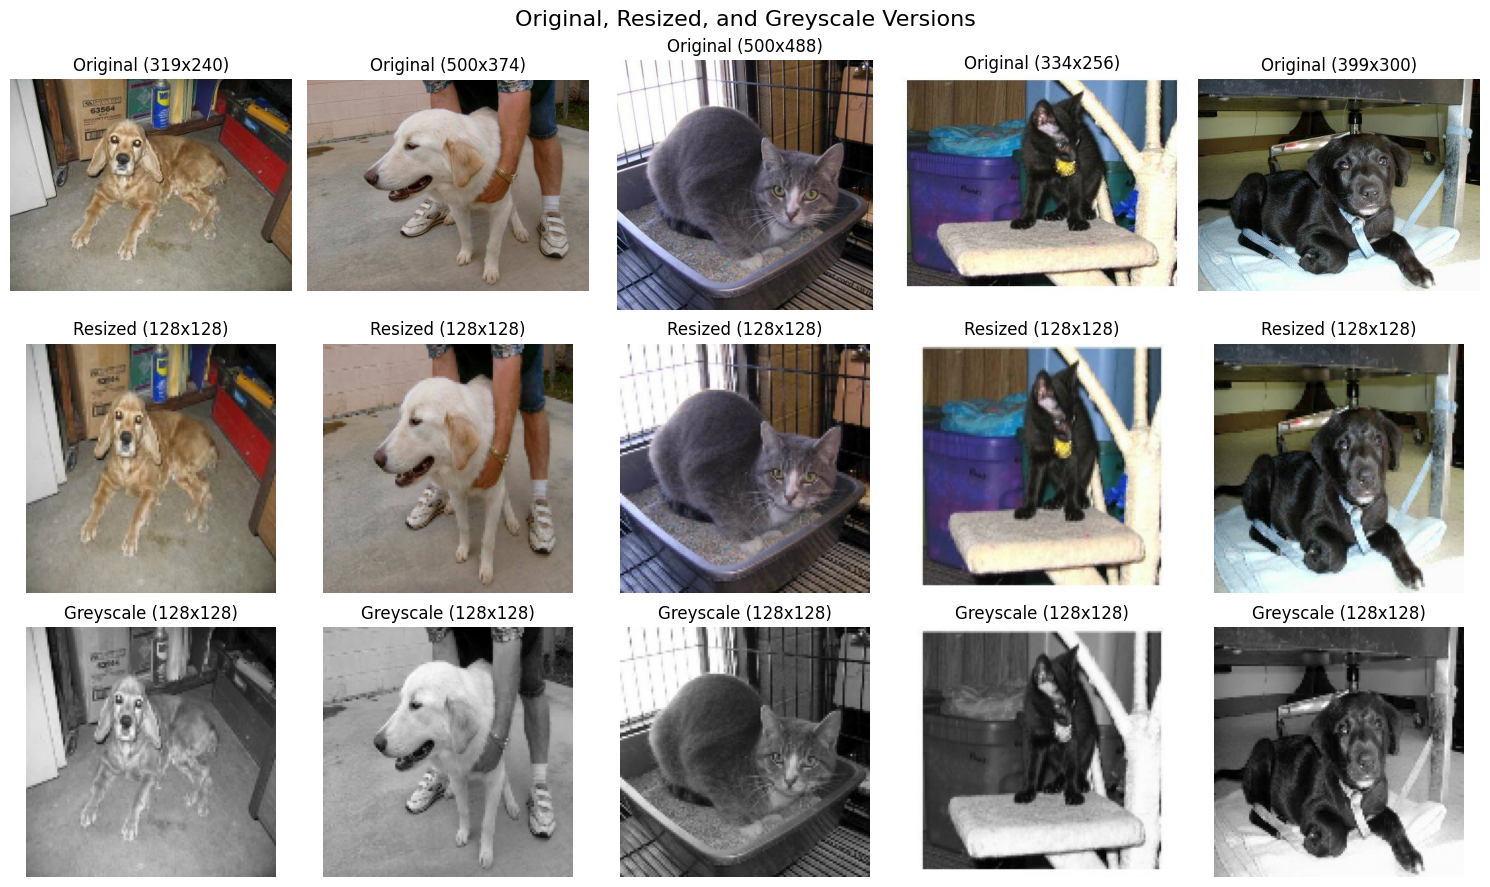

In [19]:
import random

# Select 5 random images for visualisation
sample_indices = random.sample(range(len(image_files)), 5)

# Plot original, resized, and greyscale images side by side
fig, ax = plt.subplots(3, 5, figsize=(15, 9))

for i, idx in enumerate(sample_indices):
    # Load original image (BGR to RGB)
    original = cv2.cvtColor(cv2.imread(image_files[idx]), cv2.COLOR_BGR2RGB)

    # Get resized version (already normalised and 128x128)
    resized = processed_images[idx]

    # Convert resized image to greyscale
    greyscale = cv2.cvtColor((resized * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Show original (top row)
    ax[0, i].imshow(original)
    ax[0, i].axis('off')
    ax[0, i].set_title(f"Original ({original.shape[1]}x{original.shape[0]})")

    # Show resized colour image (middle row)
    ax[1, i].imshow(resized)
    ax[1, i].axis('off')
    ax[1, i].set_title("Resized (128x128)")

    # Show greyscale version (bottom row)
    ax[2, i].imshow(greyscale, cmap='gray')
    ax[2, i].axis('off')
    ax[2, i].set_title("Greyscale (128x128)")

plt.suptitle("Original, Resized, and Greyscale Versions", fontsize=16)
plt.tight_layout()
plt.show()


## What have we learnt?
Exploring your data first is essential. It helps you spot problems early—like missing images, wrong formats, or uneven numbers of cats and dogs.  Looking at sample images lets you check that everything looks right before training a model.  Checking image sizes and formats makes sure they’re consistent, which is important for the model to work properly.  Simple stats and visual checks help you understand what kind of data you're working with and whether anything needs fixing.  

The key takeaway is that good preparation leads to better results. Taking time to explore and clean your data makes your model more accurate and reliable in the long run.